In [1]:
# I am going to stimulate transformer model foward pass from scratch and see how at every layer the output changes and its shape

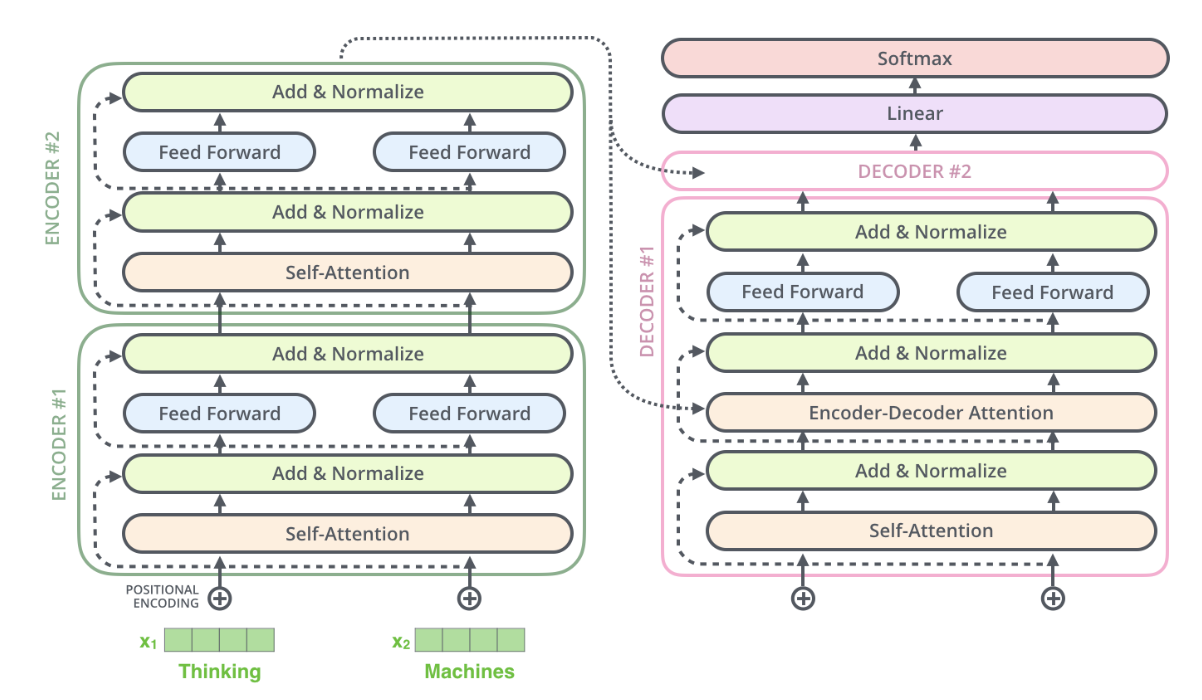

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


In [3]:
# First cerate a matrix of shape (batch_size, seq_len, d_model)

batch_size = 32
seq_len = 100
d_model = 512

x = torch.randn(batch_size, seq_len, d_model)

 
    
# Now I am going to create a transformer model just by using nn.Linear


nhead = 8
# num_encoder_layers = 6
# num_decoder_layers = 6
dim_feedforward = 2048
dropout = 0.1


# Encoder Side

In [4]:
x.shape

torch.Size([32, 100, 512])

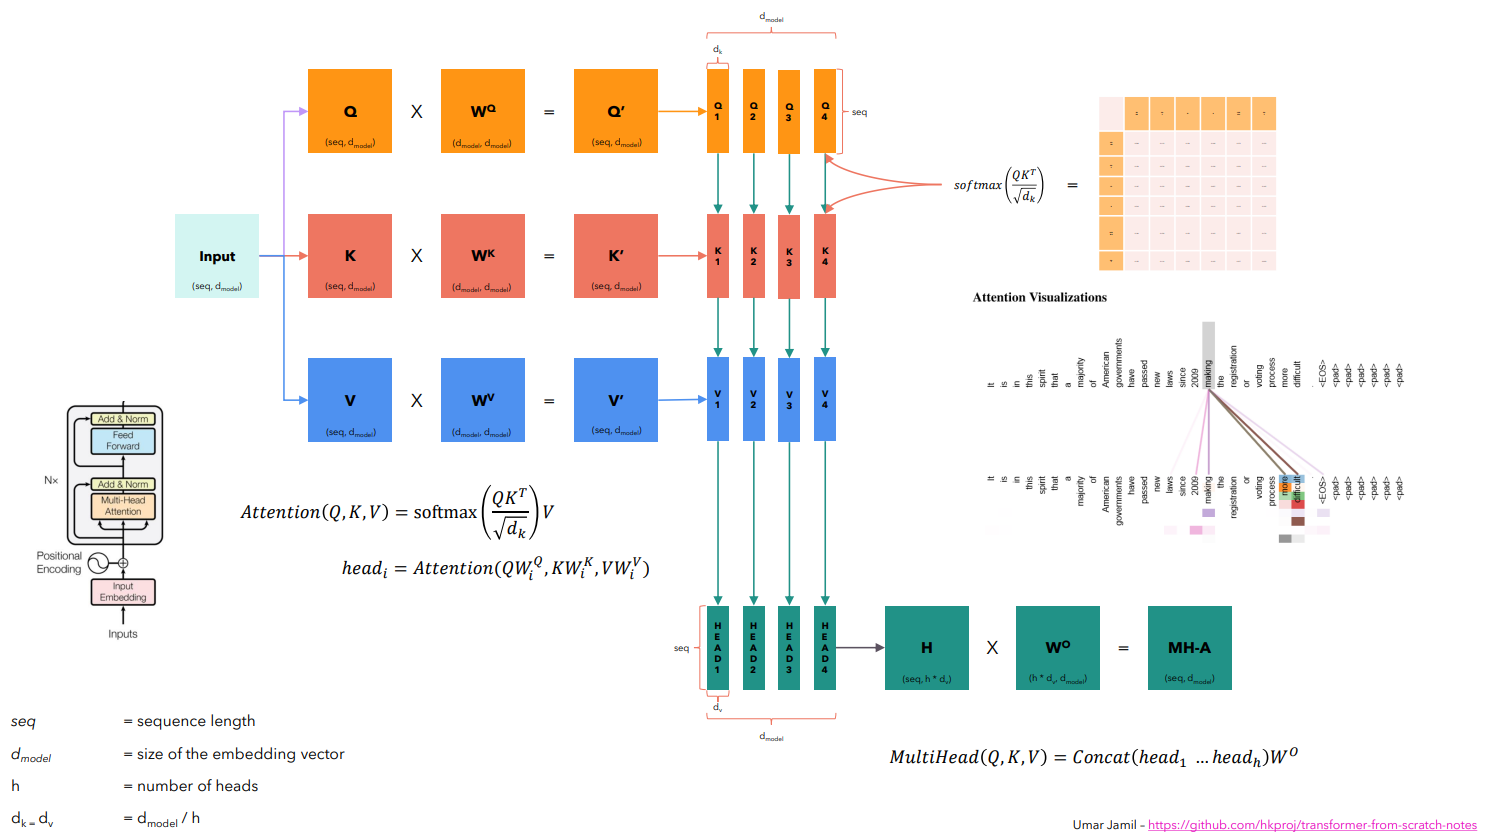

In [5]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        
        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)  
        return self.w_o(x)

## Lets assume we have maximum sequence length of 100 and we have a word length of 50 including starting and ending token we will pad the rest of the sequence with 0

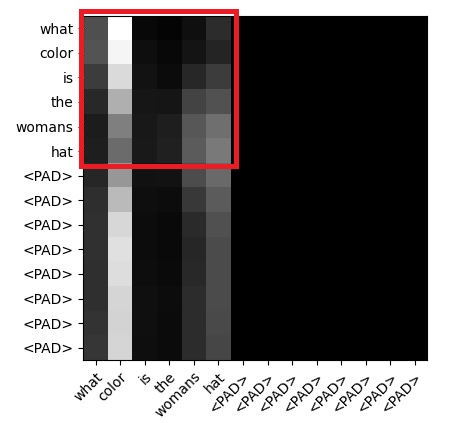


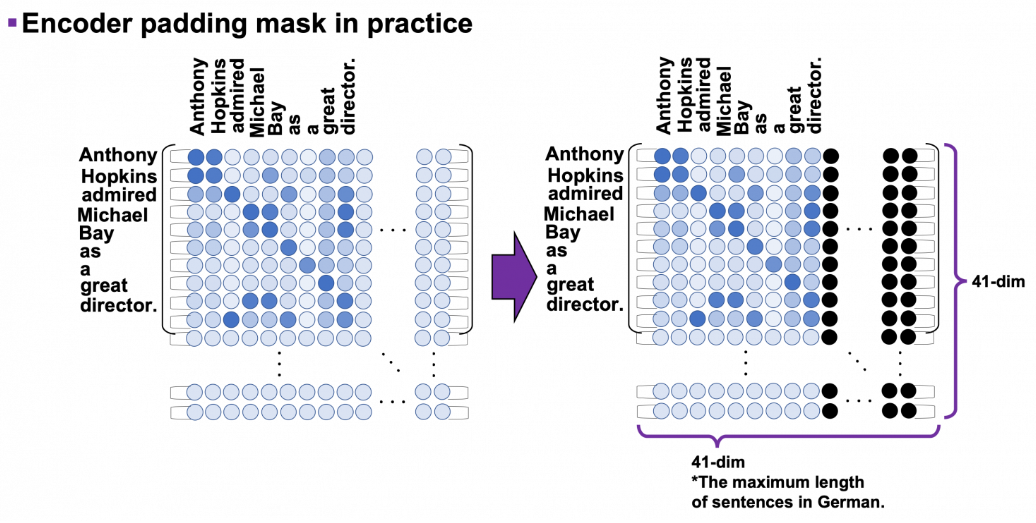



In [31]:

# Creating a mask for the encoder self attention heads
enc_mask = torch.zeros(seq_len)
enc_mask[:50] = 1
enc_mask = enc_mask.unsqueeze(0).unsqueeze(0).unsqueeze(0)
enc_mask

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [32]:
enc_mask.shape

torch.Size([1, 1, 1, 100])

In [33]:
Encoder_self_Attention = MultiHeadAttentionBlock(d_model, nhead, dropout)

In [34]:
Attention_x = Encoder_self_Attention(x, x, x, enc_mask)

In [35]:
Attention_x.shape

torch.Size([32, 100, 512])

## Layer-Normalization Block and Residual Connection Encoder



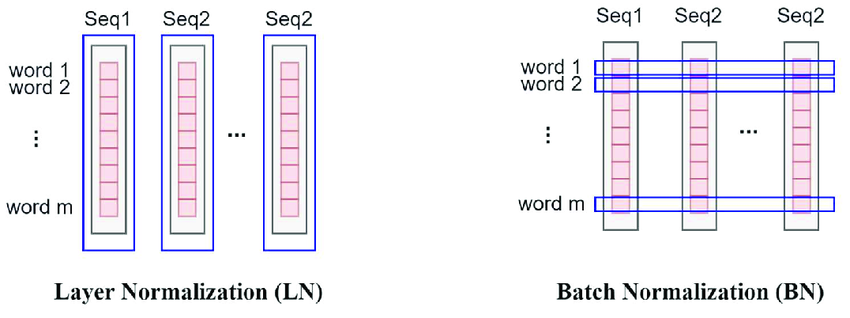

In [36]:
class LayerNormalization(nn.Module):

    def __init__(self, features: int, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(features)) # alpha is a learnable parameter
        self.bias = nn.Parameter(torch.zeros(features)) # bias is a learnable parameter

    def forward(self, x):
        # x: (batch, seq_len, hidden_size)
         # Keep the dimension for broadcasting
        mean = x.mean(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # Keep the dimension for broadcasting
        std = x.std(dim = -1, keepdim = True) # (batch, seq_len, 1)
        # eps is to prevent dividing by zero or when std is very small
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

In [37]:
class ResidualConnection(nn.Module):
    
    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(features)

    def forward(self, x, prevlayer_x):
        return x + self.dropout(self.norm(prevlayer_x))

In [38]:
Residual1 = ResidualConnection(d_model, dropout)

In [39]:
x = Residual1(x, Attention_x)
x.shape

torch.Size([32, 100, 512])

# Feed Forward Layer Encoder

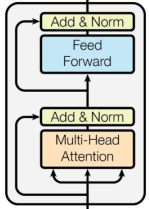

In [40]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # w1 and b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # w2 and b2

    def forward(self, x):
        # (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))
    

In [41]:
FeedLayer_Enc = FeedForwardBlock(d_model, dim_feedforward, dropout)

In [42]:
x_feed = FeedLayer_Enc(x)

In [43]:
Residual2 = ResidualConnection(d_model, dropout)
x = Residual2(x, x_feed)
x.shape

torch.Size([32, 100, 512])

# At Decoder Side

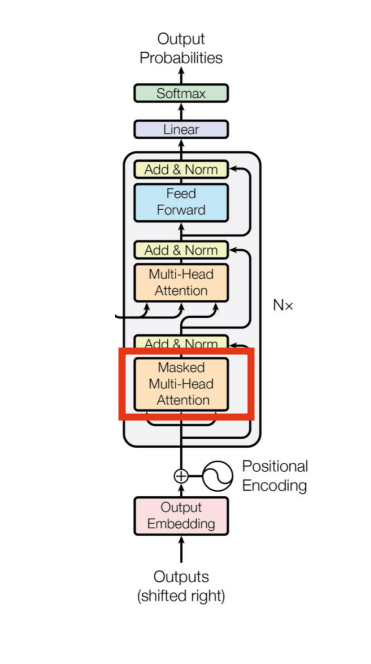

## Masked Multi-Head Attention

In [44]:

# First cerate a matrix of shape (batch_size, seq_len, d_model)

batch_size = 32
seq_len = 100
d_model = 512

Output_y = torch.randn(batch_size, seq_len, d_model)
Output_y.shape

torch.Size([32, 100, 512])

In [45]:
Decoder_self_Attention_1 = MultiHeadAttentionBlock(d_model, nhead, dropout)

### Lets create casual mask/decoder_mask for the decoder self attention heads

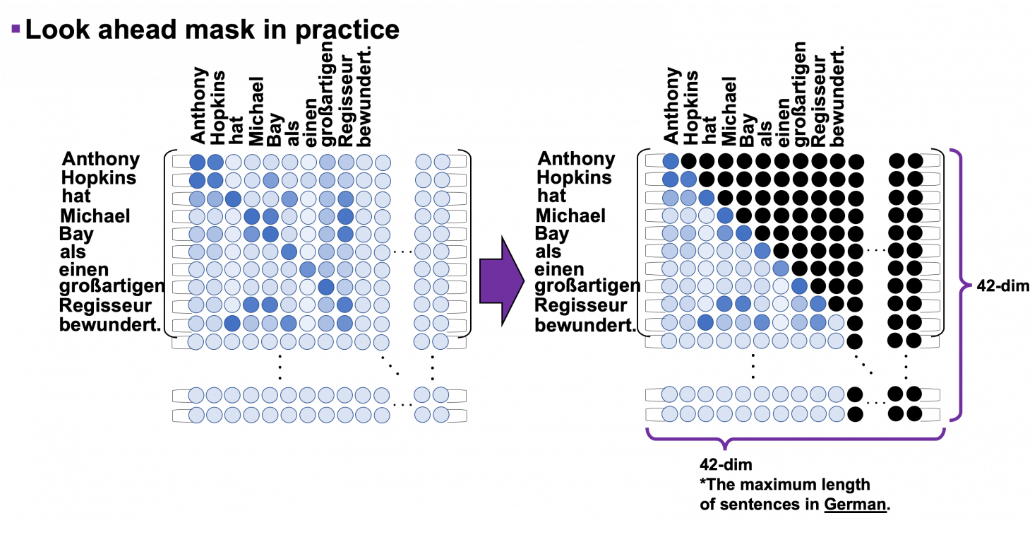

In [47]:


dec_mask_casual = torch.ones(seq_len, seq_len)
dec_mask_casual = torch.tril(dec_mask_casual)
dec_mask_casual = dec_mask_casual.unsqueeze(0).unsqueeze(0)
print(dec_mask_casual.shape)
print(dec_mask_casual)

torch.Size([1, 1, 100, 100])
tensor([[[[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])


In [57]:
# Lets create padding mask for the decoder self attention heads

dec_mask_padding = torch.zeros(seq_len)
dec_mask_padding[:40] = 1
dec_mask_padding = dec_mask_padding.unsqueeze(0).unsqueeze(0).unsqueeze(0)
dec_mask_padding.shape

torch.Size([1, 1, 1, 100])

In [51]:
# Lets Combine the paddding mask and casual mask

dec_mask_combined = dec_mask_casual * dec_mask_padding
print(dec_mask_combined)


tensor([[[[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]])


In [52]:
Attention_y_1 = Decoder_self_Attention_1(Output_y, Output_y, Output_y, dec_mask_combined)
Attention_y_1.shape

torch.Size([32, 100, 512])

## ADD and Norm Block

In [53]:
Residual3 = ResidualConnection(d_model, dropout)
Output_y = Residual3(Output_y, Attention_y_1)
Output_y.shape

torch.Size([32, 100, 512])

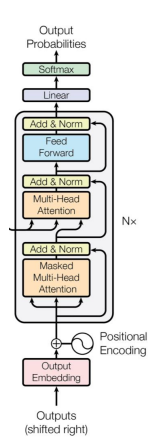

## Cross-Attention sub-layer Decoder

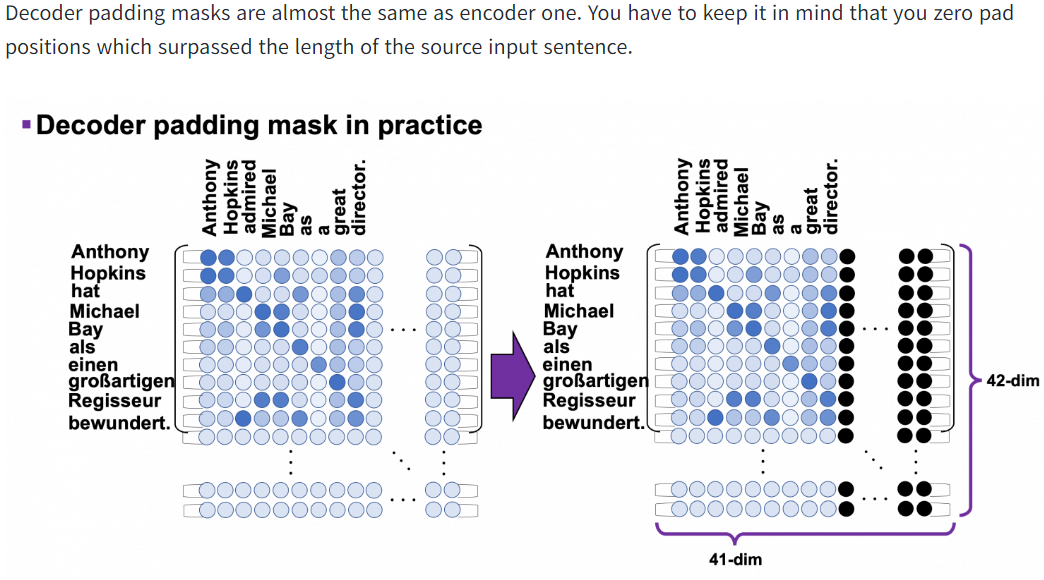

In [54]:
Decoder_self_Attention_2 = MultiHeadAttentionBlock(d_model, nhead, dropout)

Attention_y_2 = Decoder_self_Attention_2(Output_y, x, x, enc_mask)

Residual4 = ResidualConnection(d_model, dropout)

Output_y = Residual4(Output_y, Attention_y_2)

Output_y.shape

torch.Size([32, 100, 512])

## Feed Forward sub Layer Decoder

In [55]:

FeedLayer_Dec = FeedForwardBlock(d_model, dim_feedforward, dropout)

Output_y_feed = FeedLayer_Dec(Output_y)

Residual5 = ResidualConnection(d_model, dropout)

Output_y = Residual5(Output_y, Output_y_feed)

Output_y.shape


torch.Size([32, 100, 512])

# Output Linear and softmax Layer

In [56]:
# Lets assume output vocab size is 30000

output_vocab_size = 30000
Output_y = nn.Linear(d_model, output_vocab_size)(Output_y)

# Apply softmax to get the probabilities

Output_y = F.softmax(Output_y, dim=-1)

Output_y.shape


torch.Size([32, 100, 30000])